In [1]:
import numpy as np 
from tensorflow.keras import layers
from tensorflow import keras
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
data = pd.read_csv('北京空气_2010.1.1-2014.12.31.csv')
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [4]:
# 所有为空的个数
data['pm2.5'].isna().sum()

2067

In [5]:
# 使用填充法，对24个数据之后的pm2.5的缺失值填充,使用前向填充
data = data.iloc[24:].fillna(method='ffill')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 24 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [7]:
# 多列时间合并成一列，构造用于预测的
import datetime

In [8]:
datetime.datetime(year=2010, month=2, day=2, hour=1)

datetime.datetime(2010, 2, 2, 1, 0)

In [9]:
# 按行计算
data['tm'] = data.apply(lambda x: datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)

In [11]:
data.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
data = data.set_index('tm')

In [12]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
tm,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [13]:
# string 变为 int
data.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [14]:
# 独热编码风向
data = data.join(pd.get_dummies(data.cbwd))

In [15]:
del data['cbwd']
data.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
tm,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


# 把数据做成特征数据和目标数据

In [ ]:
# 用pd 自带的绘图工具绘图最后1000次 pm2.5 变化情况
data['pm2.5'][-1000:].plot()

In [ ]:
data['TEMP'][-1000:].plot()

In [16]:
# 用5天的时间，预测未来1天的数据
# 5天的样本，一天的样本
seq_length = 5*24
delay = 24

In [17]:
# 保存训练集，每6天的数据 = 一个训练样本+一个测试样本
data_ = []
for i in range(len(data) - seq_length - delay):
    data_.append(data.iloc[i: i + seq_length + delay])

In [18]:
# 一个总的序列为144个小时，11个特征
data_.shape

(144, 11)

In [20]:
# 将所有数据转化为array形式
data_ = np.array([df.values for df in data_])
# 数据量，一条数据的长度，特征数
data_.shape

# data_ = data_.to_numpy()  只能是pandas
# data_.shape

(43656, 144, 11)

In [21]:
np.random.shuffle(data_)

In [25]:
# 划分样本，所有行，每5天，所有列
x = data_[:, :5*24, :]
# 标签为一天后的一个值
y = data_[:, -1, 0]

In [26]:
x.shape, y.shape

((43656, 120, 11), (43656,))

In [27]:
split_b = int(data_.shape[0]*0.8)
split_b

34924

In [28]:
train_x = x[:split_b]
train_y = y[:split_b]
test_x = x[split_b:]
test_y = y[split_b:]

In [29]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((34924, 120, 11), (34924,), (8732, 120, 11), (8732,))

In [30]:
# 神经网络喜欢统一的数据取值范围
# 数据标准化：减均值，除方差

In [31]:
# 对列求均值
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)

In [32]:
train_x = (train_x - mean)/std
test_x = (test_x - mean)/std

# 建立模型
- 从简单的模型开始，慢慢来

In [33]:
# 多层感知机开始
BATCH_SIZE = 128

In [ ]:
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(train_x.shape[1:])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [ ]:
histoty = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=30, validation_data=(test_x, test_y))

In [ ]:
plt.plot(histoty.epoch, histoty.history['mae'], c='r')
plt.plot(histoty.epoch, histoty.history['val_mae'], c='b')

# LSTM

In [34]:
# LSTM 擅长根据时间变化的预测趋势问题
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(120,11)))
model.add(layers.Dense(1))

In [35]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [36]:
histoty = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=30, validation_data=(test_x, test_y))

Epoch 1/30
273/273 [==============================] - 13s 48ms/step - loss: 16166.7471 - mae: 88.7434 - val_loss: 14942.2012 - val_mae: 82.2261
Epoch 2/30
273/273 [==============================] - 12s 44ms/step - loss: 14331.7939 - mae: 80.1798 - val_loss: 13565.2900 - val_mae: 76.6007
Epoch 3/30
273/273 [==============================] - 12s 43ms/step - loss: 13078.0410 - mae: 75.3970 - val_loss: 12453.0908 - val_mae: 72.6307
Epoch 4/30
273/273 [==============================] - 12s 45ms/step - loss: 12050.0127 - mae: 71.8797 - val_loss: 11538.3018 - val_mae: 69.6760
Epoch 5/30
273/273 [==============================] - 12s 42ms/step - loss: 11201.9307 - mae: 69.3128 - val_loss: 10786.2041 - val_mae: 67.5892
Epoch 6/30
273/273 [==============================] - 12s 42ms/step - loss: 10509.2363 - mae: 67.5239 - val_loss: 10178.9561 - val_mae: 66.2041
Epoch 7/30
273/273 [==============================] - 12s 42ms/step - loss: 9948.6025 - mae: 66.2992 - val_loss: 9689.5576 - val_mae: 65

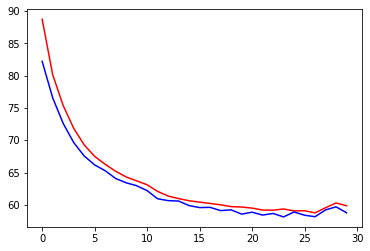

In [38]:
plt.plot(histoty.epoch, histoty.history['mae'], c='r')
plt.plot(histoty.epoch, histoty.history['val_mae'], c='b')

# 模型优化
- 堆叠LSTM
- 学习中降低学习速率

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(120,11), return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1))

In [ ]:
# 回调函数降低学习速率, 如果3个迭代过程monitor 监控的内容没有降低，则学习率*factor
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5, min_lr=0.00001)

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [ ]:
histoty = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=20, callbacks=[lr_reduce], validation_data=(test_x, test_y))

In [ ]:
plt.plot(histoty.epoch, histoty.history['mae'], c='r')
plt.plot(histoty.epoch, histoty.history['val_mae'], c='b')

In [39]:
model.save('pm2.5.h5')

# 模型评价

In [ ]:
model.evaluate(test_x, test_y)

# 模型预测

In [ ]:
# 模型预测, 多条预测
pre_test = model.predict(test_x)
pre_test[:5]

In [37]:
data.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
tm,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [41]:
# 模型预测，单条预测
# 预测全新的数据，这次观测最后一条样本数据的下一天
# 重新做一天数据预处理
data_test = data[-120:]
# data_test = data_test.iloc[:, 5:]

In [ ]:
# data_test = data_test.join(pd.get_dummies(data_test.cbwd))
# data_test.drop('cbwd', axis=1, inplace=True)
data_test = data_test(data_test- mean)/std

In [42]:
data_test = data_test.to_numpy()
data_test.shape

(120, 11)

In [43]:
data_test = np.expand_dims(data_test, 0)

In [44]:
data_test.shape

(1, 120, 11)

In [46]:
model.predict(data_test)

array([[27.667368]], dtype=float32)